# Purpose
This notebook describes the typical activities carried out  at the beginning to a project / thread when customer shares new data. We will be trying to understand the tables, columns and information flow. Typically we also look for data issues and confirm with respective owners for resolution. At the end of this activity, the data sources and their treatment is finalized. Code in this notebook will not be part of the production code.

# Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
%%time

# Third-party imports
import os.path as op
import pandas as pd
import great_expectations as ge
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import STL
from IPython.display import display
pd.set_option('display.max_rows', 500)

# Project imports
from ta_lib.core.api import display_as_tabs, initialize_environment,save_dataset

# Initialization
initialize_environment(debug=False, hide_warnings=True)

CPU times: user 8.85 ms, sys: 1.14 ms, total: 9.99 ms
Wall time: 22.9 ms


# Data loading

In [3]:
from ta_lib.core.api import create_context, list_datasets, load_dataset

In [115]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

In [116]:
list_datasets(context)

['/raw/sales',
 '/raw/google_search',
 '/raw/social_media',
 '/raw/product_manufacturer_list',
 '/raw/Theme_product_list',
 '/raw/Theme_list',
 '/processed_data/sales',
 '/processed_data/google_search',
 '/processed_data/social_media',
 '/processed_data/product_manufacturer_list',
 '/processed_data/Theme_product_list',
 '/processed_data/Theme_list',
 '/merged_data/sales',
 '/merged_data/google_search',
 '/merged_data/social_media',
 '/merged_data/product_manufacturer_list',
 '/merged_data/Theme_product_list',
 '/merged_data/Theme_list',
 '/cleaned/orders',
 '/cleaned/product',
 '/cleaned/sales',
 '/processed/sales',
 '/train/sales/features',
 '/train/sales/target',
 '/test/sales/features',
 '/test/sales/target',
 '/score/sales/output']

In [7]:
google_search_data = load_dataset(context,'/raw/google_search')
product_manufacturer_list = load_dataset(context,'raw/product_manufacturer_list')
sales_data = load_dataset(context,'raw/sales')
social_media_data = load_dataset(context,'raw/social_media')
Theme_product_list = load_dataset(context,'raw/Theme_product_list')
Theme_list = load_dataset(context,'raw/Theme_list')

# Data Preperation

In [8]:
len(social_media_data)

533390

In [9]:
Theme_list.columns

Index(['CLAIM_ID', 'Claim Name'], dtype='object')

In [10]:
len(Theme_list)

208

In [11]:
display(sales_data.head(3).style.set_caption('sales_data'),
        social_media_data.head(3).style.set_caption('social_media_data'),
        google_search_data.head(3).style.set_caption('google_search_data'),
        Theme_product_list.head(3).style.set_caption('Theme_product_list'),
        product_manufacturer_list.head(3).style.set_caption('product_manufacturer_list'),
        Theme_list.head(3).style.set_caption('Theme_list'))

,system_calendar_key_N,product_id,sales_dollars_value,sales_units_value,sales_lbs_value
0,20160109,1,13927.000000,934,18680
1,20160109,3,10289.000000,1592,28646
2,20160109,4,357.000000,22,440


,Theme Id,published_date,total_post
0,148.000000,10-01-2015,76
1,148.000000,10-10-2015,31
2,148.000000,10-11-2015,65


,date,platform,searchVolume,Claim_ID,week_number,year_new
0,05-01-2014,google,349,916,1,2014
1,06-01-2014,google,349,916,2,2014
2,07-01-2014,google,697,916,2,2014


,PRODUCT_ID,CLAIM_ID
0,26,8
1,29,8
2,48,81


,PRODUCT_ID,Vendor,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,1,Others,nan,nan,nan,nan,nan
1,2,Others,nan,nan,nan,nan,nan
2,3,Others,nan,nan,nan,nan,nan


,CLAIM_ID,Claim Name
0,0,No Claim
1,8,low carb
2,15,beans


### Basic cleaning and formatting of all five data sources

In [12]:
#sales_data
sales_data['system_calendar_key_N'] = pd.to_datetime(sales_data['system_calendar_key_N'].astype(str), format='%Y%m%d')
sales_data.rename(columns={'system_calendar_key_N': 'date'}, inplace=True)

#social_media_data
social_media_data['published_date'] = pd.to_datetime(social_media_data['published_date'], errors='coerce')
social_media_data.rename(columns={'published_date': 'date', 'Theme Id': 'theme_id'}, inplace=True)

#google_search_data
google_search_data['date'] = pd.to_datetime(google_search_data['date'], format='%d-%m-%Y')
google_search_data.rename(columns={'Claim_ID': 'theme_id'}, inplace=True)
google_search_data.drop(columns=['week_number', 'year_new'], inplace=True)


#Theme_product_list
Theme_product_list.rename(columns={'PRODUCT_ID': 'product_id', 'CLAIM_ID': 'theme_id'}, inplace=True)

#product_manufacturer_list
product_manufacturer_list.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4','Unnamed: 5', 'Unnamed: 6'], inplace=True)
product_manufacturer_list.rename(columns={'PRODUCT_ID': 'product_id', 'Vendor': 'vendor'}, inplace=True)

#Theme_list
Theme_list.rename(columns={'CLAIM_ID': 'theme_id', 'Claim Name': 'theme_name'}, inplace=True)

In [13]:
# Checking data sources after performing above basic cleaning

display(sales_data.head(3).style.set_caption('sales_data'),
        social_media_data.head(3).style.set_caption('social_media_data'),
        google_search_data.head(3).style.set_caption('google_search_data'),
        Theme_product_list.head(3).style.set_caption('Theme_product_list'),
        product_manufacturer_list.head(3).style.set_caption('product_manufacturer_list'),
        Theme_list.head(3).style.set_caption('Theme_list'))

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value
0,2016-01-09 00:00:00,1,13927.000000,934,18680
1,2016-01-09 00:00:00,3,10289.000000,1592,28646
2,2016-01-09 00:00:00,4,357.000000,22,440


,theme_id,date,total_post
0,148.000000,2015-10-01 00:00:00,76
1,148.000000,2015-10-10 00:00:00,31
2,148.000000,2015-10-11 00:00:00,65


,date,platform,searchVolume,theme_id
0,2014-01-05 00:00:00,google,349,916
1,2014-01-06 00:00:00,google,349,916
2,2014-01-07 00:00:00,google,697,916


,product_id,theme_id
0,26,8
1,29,8
2,48,81


,product_id,vendor
0,1,Others
1,2,Others
2,3,Others


,theme_id,theme_name
0,0,No Claim
1,8,low carb
2,15,beans


# Exploratory Analysis

We have a raw data, we would now like to explore and learn more details about the data.


The output of the step would be a summary report and discussion of any pertinent findings.


In [14]:
# Import the eda API
import ta_lib.eda.api as eda

## Variable summary

In [15]:
display_as_tabs([('sales_data', sales_data.shape),
                 ('social_media_data', social_media_data.shape),
                 ('google_search_data', google_search_data.shape), 
                 ('Theme_product_list', Theme_product_list.shape),
                 ('product_manufacturer_list', product_manufacturer_list.shape),
                 ('Theme_list', Theme_list.shape)])


Tabs
    [0] Str(tuple, name='sales_data')
    [1] Str(tuple, name='social_media_data')
    [2] Str(tuple, name='google_search_data')
    [3] Str(tuple, name='Theme_product_list')
    [4] Str(tuple, name='product_manufacturer_list...)
    [5] Str(tuple, name='Theme_list')

In [16]:
sales_sum = eda.get_variable_summary(sales_data)
social_media_data_sum = eda.get_variable_summary(social_media_data)
google_search_data_sum = eda.get_variable_summary(google_search_data)
Theme_product_list_sum = eda.get_variable_summary(Theme_product_list)
product_manufacturer_list_sum = eda.get_variable_summary(product_manufacturer_list)
Theme_list_sum = eda.get_variable_summary(Theme_list)


display_as_tabs([('sales_data', sales_sum),
                ('social_media_data', social_media_data_sum),
                ('google_search_data', google_search_data_sum),
                ('Theme_product_list', Theme_product_list_sum),
                ('product_manufacturer_list', product_manufacturer_list_sum),
                ('Theme_list', Theme_list_sum)])


Tabs
    [0] DataFrame(height=300, name='sales_data', sizing_mode='fixed', value=                          ..., width=800)
    [1] DataFrame(height=300, name='social_media_data', sizing_mode='fixed', value=           Variable Name  ..., width=800)
    [2] DataFrame(height=300, name='google_search_data', sizing_mode='fixed', value=             Variable Name..., width=800)
    [3] DataFrame(height=300, name='Theme_product_list', sizing_mode='fixed', value=           Variable Name D..., width=800)
    [4] DataFrame(height=300, name='product_manufacturer_list..., sizing_mode='fixed', value=           Variable Name D..., width=800)
    [5] DataFrame(height=300, name='Theme_list', sizing_mode='fixed', value=           Variable Name D..., width=800)

## Health Analysis

Get an overview of the overall health of the dataset. This is usually quick to compute and hopefully highlights some problems to focus on.



### Summary Plot

Provides a high level summary of the dataset health.

**Watching out for:**

* too few numeric values
* high % of missing values
* high % of duplicate values
* high % of duplicate columns 

In [17]:
sum1, plot1 = eda.get_data_health_summary(sales_data, return_plot=True)
sum2, plot2 = eda.get_data_health_summary(social_media_data, return_plot=True)
sum3, plot3 = eda.get_data_health_summary(google_search_data, return_plot=True)
sum4, plot4 = eda.get_data_health_summary(Theme_product_list, return_plot=True)
sum5, plot5 = eda.get_data_health_summary(product_manufacturer_list, return_plot=True)
sum6, plot6 = eda.get_data_health_summary(Theme_list, return_plot=True)

display_as_tabs([('sales_data', plot1),
                ('social_media_data', plot2),
                ('google_search_data', plot3),
                ('Theme_product_list', plot4),
                ('product_manufacturer_list', plot5),
                ('Theme_list', plot6)])

Tabs
    [0] HoloViews(Layout, name='sales_data')
    [1] HoloViews(Layout, name='social_media_data')
    [2] HoloViews(Layout, name='google_search_data')
    [3] HoloViews(Layout, name='Theme_product_list')
    [4] HoloViews(Layout, name='product_manufacturer_list...)
    [5] HoloViews(Layout, name='Theme_list')

**Dev NOTES**

<details>
    
- **Sales_data**
1. Datatypes : We have both numeric and other types. The bulk of them seem to be numeric. `Numeric` is defined to be one of [float|int|date] .A column is assumed to have `date` values if it has the string `date` in the column name.

2. The missing value plot seems to indicate missing values are not present but we do have them. 

3. We are looking for duplicate observations (rows in the data). The plot shows the % of rows that are an exact replica of another row (using `df.duplicated`)

4. We are looking for duplicate features (columns in the data).
    
- **social_media_data**
1. Datatypes : We have both numeric and other types. The bulk of them seem to be numeric. `Numeric` is defined to be one of [float|int|date] .

2. The missing value plot seems to indicate missing values are present in Theme Id. 

3. We are looking for duplicate observations (rows in the data). The plot shows the % of rows that are an exact replica of another row (using `df.duplicated`)

4. We are looking for duplicate features (columns in the data).
    
- **google_search_data**
1. Datatypes : We have both numeric and other types. The bulk of them seem to be numeric.

2. The missing value plot seems to indicate missing values are not present. 

3. We are looking for duplicate observations (rows in the data). The plot shows the % of rows that are an exact replica of another row (using `df.duplicated`)

4. We are looking for duplicate features (columns in the data). Very less duplicate rows present.


- **Theme_product_list**
1. Datatypes : We have only numeric type .

2. The missing value plot seems to indicate missing values are not present. 

3. We are looking for duplicate observations (rows in the data). The plot shows the % of rows that are an exact replica of another row (using `df.duplicated`)

4. We are looking for duplicate features (columns in the data). No duplicate rows present.
    
    
- **product_manufacturer_list**
1. Datatypes :  We have both numeric and other types. The bulk of them seem to be numeric.

2. The missing value plot seems to indicate missing values are not present. 

3. We are looking for duplicate observations (rows in the data). The plot shows the % of rows that are an exact replica of another row (using `df.duplicated`)

4. We are looking for duplicate features (columns in the data). No duplicate rows present.
    
- **Theme_list**
1. Datatypes :  We have both numeric and other types.

2. The missing value plot seems to indicate missing values are not present. 

3. We are looking for duplicate observations (rows in the data). The plot shows the % of rows that are an exact replica of another row (using `df.duplicated`)

4. We are looking for duplicate features (columns in the data). No duplicate rows present.
</details>

### Missing Values summary

This provides an overall view focussing on amount of missing values in the dataset.

**Watch out for:**
* A few columns have significant number of missing values 
* Most columns have significant number of missing values


In [18]:
sum1, plot1 = eda.get_missing_values_summary(sales_data, return_plot=True)
sum2, plot2 = eda.get_missing_values_summary(social_media_data, return_plot=True)
sum3, plot3 = eda.get_missing_values_summary(google_search_data, return_plot=True)
sum4, plot4 = eda.get_missing_values_summary(Theme_product_list, return_plot=True)
sum5, plot5 = eda.get_missing_values_summary(product_manufacturer_list, return_plot=True)
sum6, plot6 = eda.get_missing_values_summary(Theme_list, return_plot=True)

display_as_tabs([('sales_data', plot1),
                ('social_media_data', plot2),
                ('google_search_data', plot3),
                ('Theme_product_list', plot4),
                ('product_manufacturer_list', plot5),
                ('Theme_list', plot6)])

Tabs
    [0] HoloViews(Bars, name='sales_data')
    [1] HoloViews(Bars, name='social_media_data')
    [2] HoloViews(Bars, name='google_search_data')
    [3] HoloViews(Bars, name='Theme_product_list')
    [4] HoloViews(Bars, name='product_manufacturer_list...)
    [5] HoloViews(Bars, name='Theme_list')

**Dev notes:**

<details>
    
    * By default, the following are considered missing/NA values : `[np.Nan, pd.NaT, 'NA', None]`
    * additional values can be passed to tigerml (add_additional_na_values)
    * these are applied to all columns.
    
    * some of the above information can be learnt from the data discovery step (see discussion below)
    
</details>

In [19]:
sum1  = eda.get_duplicate_columns(sales_data)
sum2  = eda.get_duplicate_columns(social_media_data)
sum3  = eda.get_duplicate_columns(google_search_data)
sum4  = eda.get_duplicate_columns(Theme_product_list)
sum5  = eda.get_duplicate_columns(product_manufacturer_list)
sum6  = eda.get_duplicate_columns(Theme_list)


display_as_tabs([('sales_data', sum1),
                ('social_media_data', sum2),
                ('google_search_data', sum3),
                ('Theme_product_list', sum4),
                ('product_manufacturer_list', sum5),
                ('Theme_list', sum6)])



Tabs
    [0] Markdown(str, name='sales_data')
    [1] Markdown(str, name='social_media_data')
    [2] Markdown(str, name='google_search_data')
    [3] Markdown(str, name='Theme_product_list')
    [4] Markdown(str, name='product_manufacturer_list...)
    [5] Markdown(str, name='Theme_list')

## Health Analysis report

Generate a report that has all the above data in a single html. This could be useful to submit to a client

In [139]:
from ta_lib.reports.api import summary_report

summary_report(sales_data, './sales.html')
summary_report(social_media_data, './social_media_data.html')
summary_report(google_search_data, './google_search_data.html')
summary_report(Theme_product_list, './Theme_product_list.html')
summary_report(product_manufacturer_list, './product_manufacturer_list.html')
summary_report(Theme_list, './Theme_list.html')

2023-06-09 19:26:32 - ERROR - tigerml.eda.plotters.health_analysis.HealthMixin::inner::197 - Cannot compute health_analysis. Error - [Errno 2] No such file or directory: '/mnt/c/Users/rajat.kurhade/Desktop/rajat/Assignment_5.2/src/ta_lib/_vendor/tigerml/core/reports/html/report_resources/template.html'
Traceback (most recent call last):
  File "/mnt/c/Users/rajat.kurhade/Desktop/rajat/Assignment_5.2/src/ta_lib/_vendor/tigerml/core/utils/_lib.py", line 195, in inner
    return func(*args, **kwargs)
  File "/mnt/c/Users/rajat.kurhade/Desktop/rajat/Assignment_5.2/src/ta_lib/_vendor/tigerml/core/utils/_lib.py", line 213, in inner
    result = func(*args, **kwargs)
  File "/mnt/c/Users/rajat.kurhade/Desktop/rajat/Assignment_5.2/src/ta_lib/_vendor/tigerml/eda/plotters/health_analysis/HealthMixin.py", line 459, in health_analysis
    create_report(
  File "/mnt/c/Users/rajat.kurhade/Desktop/rajat/Assignment_5.2/src/ta_lib/_vendor/tigerml/core/reports/lib.py", line 23, in create_report
    cre

Error: Failed to create report : Cannot compute health_analysis. Error - [Errno 2] No such file or directory: '/mnt/c/Users/rajat.kurhade/Desktop/rajat/Assignment_5.2/src/ta_lib/_vendor/tigerml/core/reports/html/report_resources/template.html'2023-06-09 19:26:39 - ERROR - tigerml.eda.plotters.health_analysis.HealthMixin::inner::197 - Cannot compute health_analysis. Error - [Errno 2] No such file or directory: '/mnt/c/Users/rajat.kurhade/Desktop/rajat/Assignment_5.2/src/ta_lib/_vendor/tigerml/core/reports/html/report_resources/template.html'
Traceback (most recent call last):
  File "/mnt/c/Users/rajat.kurhade/Desktop/rajat/Assignment_5.2/src/ta_lib/_vendor/tigerml/core/utils/_lib.py", line 195, in inner
    return func(*args, **kwargs)
  File "/mnt/c/Users/rajat.kurhade/Desktop/rajat/Assignment_5.2/src/ta_lib/_vendor/tigerml/core/utils/_lib.py", line 213, in inner
    result = func(*args, **kwargs)
  File "/mnt/c/Users/rajat.kurhade/Desktop/rajat/Assignment_5.2/src/ta_lib/_vendor/tiger

### Sales Data

In [21]:
#function to check time_granularity

def check_time_granularity(df):
    # Calculate time differences
    time_diff = pd.Series(df['date'].unique()).sort_values().diff()

    # Analyze time differences
    time_diff_mean = time_diff.mean()
    time_diff_std = time_diff.std()

    if time_diff_mean == pd.Timedelta(days=1):
        print("Daily granularity")
    elif time_diff_mean == pd.Timedelta(days=7):
        print("Weekly granularity")
    elif time_diff_mean >= pd.Timedelta(days=28) and time_diff_mean <= pd.Timedelta(days=31):
        print("Monthly granularity")
    elif time_diff_mean >= pd.Timedelta(days=90) and time_diff_mean <= pd.Timedelta(days=92):
        print("Quarterly granularity")
    elif time_diff_mean >= pd.Timedelta(days=365) or time_diff_mean % pd.Timedelta(days=365) == pd.Timedelta(days=0):
        print("Yearly granularity")
    else:
        print("Unknown granularity")

    print("Mean time difference:", time_diff_mean)
    print("Standard deviation of time difference:", time_diff_std)

In [22]:
sales_data.head(5)

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value
0,2016-01-09,1,13927.0,934,18680
1,2016-01-09,3,10289.0,1592,28646
2,2016-01-09,4,357.0,22,440
3,2016-01-09,6,23113.0,2027,81088
4,2016-01-09,7,23177.0,3231,58164


In [23]:
check_time_granularity(sales_data)

Weekly granularity
Mean time difference: 7 days 00:00:00
Standard deviation of time difference: 0 days 00:00:00


In [13]:
#no missing
#Weekly granularity
#sales_dollar_value: Zeros (%)	0.4%, Kurtosis	384.77029, Skewness	13.850391
#sales_units_value: Kurtosis	233.33228, Skewness	13.375651
#sales_lbs_value: Zeros (%)	1.2%, Kurtosis	1450.5147, Skewness	30.217483

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the sales_data is already loaded into a pandas DataFrame called 'df'

# Calculate the IQR
Q1 = sales_data['sales_dollars_value'].quantile(0.25)
Q3 = sales_data['sales_dollars_value'].quantile(0.75)
IQR = Q3 - Q1

# Determine the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find the outliers
outliers = sales_data[(sales_data['sales_dollars_value'] < lower_bound) | (sales_data['sales_dollars_value'] > upper_bound)]

# Generate a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=sales_data[sales_data.sales_dollars_value>1000000]['sales_dollars_value'])
plt.xlabel('Sales Dollars Value')
plt.title('Box Plot of Sales Dollars Value')
plt.show()

# Print the outliers
print("Outliers in Sales Dollars Value:")
print(outliers)


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Outliers in Sales Dollars Value:
              date  product_id  sales_dollars_value  sales_units_value  \
5       2016-01-09           8              47729.0               3914   
6       2016-01-09           9             304750.0              19619   
8       2016-01-09          12              36104.0               2114   
12      2016-01-09          17             141263.0               5059   
13      2016-01-09          18             147382.0               9050   
...            ...         ...                  ...                ...   
4526031 2018-10-27       47192             138871.0              14127   
4526050 2018-10-27       47245              41311.0               6199   
4526104 2018-10-27       47369              41780.0               4252   
4526131 2018-10-27       47432              29924.0               2023   
4526135 2018-10-27       47441              46577.0               1058   

         sales_lbs_value  
5                  78288  
6                 784769

In [25]:
len(sales_data)

4526182

In [26]:
631281/4526182

0.1394731807072716

#### sales_dollar_value:imputation

In [27]:
sales_data[sales_data.sales_lbs_value==0].head(5)

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value
26,2016-01-09,116,3.0,3,0
310,2016-01-09,34090,2.0,1,0
311,2016-01-09,34092,7.0,2,0
314,2016-01-09,34103,12.0,2,0
315,2016-01-09,34106,2.0,1,0


In [28]:
sales_data[sales_data.product_id==34090]

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value
310,2016-01-09,34090,2.0,1,0
45684,2016-01-23,34090,2.0,1,0
67931,2016-02-06,34090,4.0,3,1
86236,2016-01-30,34090,2.0,1,0
113119,2016-02-13,34090,0.0,1,0
123822,2016-02-20,34090,2.0,1,0
151888,2016-02-27,34090,2.0,2,0
175859,2016-03-05,34090,4.0,2,0
209464,2016-03-12,34090,2.0,1,0
378267,2016-05-07,34090,2.0,1,0


In [91]:
# Step 1: Identify rows with zero sales_lbs_value
zero_sales_rows = sales_data[sales_data['sales_lbs_value'] == 0]

# Step 2 and 3: Calculate average value for nonzero sales_lbs_value rows
grouped = sales_data[sales_data['sales_lbs_value'] != 0].groupby('product_id')
get_imputed_value = lambda row: grouped.get_group(row['product_id'])['sales_lbs_value'].sum() / grouped.get_group(row['product_id'])['sales_units_value'].sum() if row['product_id'] in grouped.groups else 0
imputed_values = zero_sales_rows.apply(get_imputed_value, axis=1)

# Step 4: Replace zero sales_lbs_value with the imputed values
sales_data.loc[sales_data['sales_lbs_value'] == 0, 'sales_lbs_value'] = imputed_values * zero_sales_rows['sales_units_value']

# Print the updated DataFrame
sales_data[sales_data.product_id==34090]

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value
310,2016-01-09,34090,2.0,1,0.222222
45684,2016-01-23,34090,2.0,1,0.222222
67931,2016-02-06,34090,4.0,3,1.000000
86236,2016-01-30,34090,2.0,1,0.222222
113119,2016-02-13,34090,0.0,1,0.222222
123822,2016-02-20,34090,2.0,1,0.222222
151888,2016-02-27,34090,2.0,2,0.444444
175859,2016-03-05,34090,4.0,2,0.444444
209464,2016-03-12,34090,2.0,1,0.222222
378267,2016-05-07,34090,2.0,1,0.222222


In [29]:
len(sales_data[sales_data.sales_lbs_value==0])/len(sales_data)

0.011868722910391143

In [21]:
#sales_lbs_value: Zeros (%)	1.2%->0.05%

#### sales_dollars_value:imputation

In [30]:
sales_data[sales_data.sales_dollars_value==0].head(5)

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value
149,2016-01-09,11443,0.0,19,7
400,2016-01-09,46133,0.0,3,1
685,2016-01-09,11589,0.0,24,9
1210,2016-01-09,11707,0.0,43,16
1589,2016-01-09,35076,0.0,4,1


In [31]:
sales_data[sales_data.product_id==11443]

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value
149,2016-01-09,11443,0.0,19,7
13272,2016-01-16,11443,1.0,106,40
33590,2016-01-23,11443,1.0,130,49
57559,2016-01-30,11443,10.0,615,231
64197,2016-02-06,11443,11.0,659,247
105584,2016-02-13,11443,7.0,643,241
119270,2016-02-20,11443,10.0,694,260
154144,2016-02-27,11443,10.0,771,289
167216,2016-03-05,11443,8.0,820,308
196338,2016-03-12,11443,9.0,727,273


In [32]:
# Step 1: Identify rows with zero sales_dollars_value
zero_sales_rows = sales_data[sales_data['sales_dollars_value'] == 0]

# Step 2 and 3: Calculate average value for nonzero sales_dollars_value rows
grouped = sales_data[sales_data['sales_dollars_value'] != 0].groupby('product_id')
get_imputed_value = lambda row: grouped.get_group(row['product_id'])['sales_dollars_value'].sum() / grouped.get_group(row['product_id'])['sales_units_value'].sum() if row['product_id'] in grouped.groups else 0
imputed_values = zero_sales_rows.apply(get_imputed_value, axis=1)

# Step 4: Replace zero sales_lbs_value with the imputed values
sales_data.loc[sales_data['sales_dollars_value'] == 0, 'sales_dollars_value'] = imputed_values * zero_sales_rows['sales_units_value']

# Print the updated DataFrame
sales_data[sales_data.product_id==11443]

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value
149,2016-01-09,11443,0.548331,19,7
13272,2016-01-16,11443,1.000000,106,40
33590,2016-01-23,11443,1.000000,130,49
57559,2016-01-30,11443,10.000000,615,231
64197,2016-02-06,11443,11.000000,659,247
105584,2016-02-13,11443,7.000000,643,241
119270,2016-02-20,11443,10.000000,694,260
154144,2016-02-27,11443,10.000000,771,289
167216,2016-03-05,11443,8.000000,820,308
196338,2016-03-12,11443,9.000000,727,273


In [33]:
len(sales_data[sales_data.sales_dollars_value==0])/len(sales_data)

0.00020591306315123872

In [26]:
#sales_dollar_value: Zeros (%)	0.4%->0.02

In [34]:
len(sales_data)

4526182

In [35]:
pro_sales_data=sales_data[(sales_data['sales_dollars_value'] != 0) & (sales_data['sales_lbs_value'] != 0)]
len(pro_sales_data)

4471821

In [36]:
per_drop=(4526182-4523363)*100/4526182
per_drop

0.06228207350035858

In [37]:
#pro_sales_data.to_csv('processed_data/pro_sales_data.csv')

save_dataset(context, pro_sales_data, 'processed_data/sales')



### google_search_data

In [38]:
google_search_data.head()

,date,platform,searchVolume,theme_id
0,2014-01-05,google,349,916
1,2014-01-06,google,349,916
2,2014-01-07,google,697,916
3,2014-01-10,google,349,916
4,2014-01-20,google,697,916


In [39]:
check_time_granularity(google_search_data)

Daily granularity
Mean time difference: 1 days 00:00:00
Standard deviation of time difference: 0 days 00:00:00


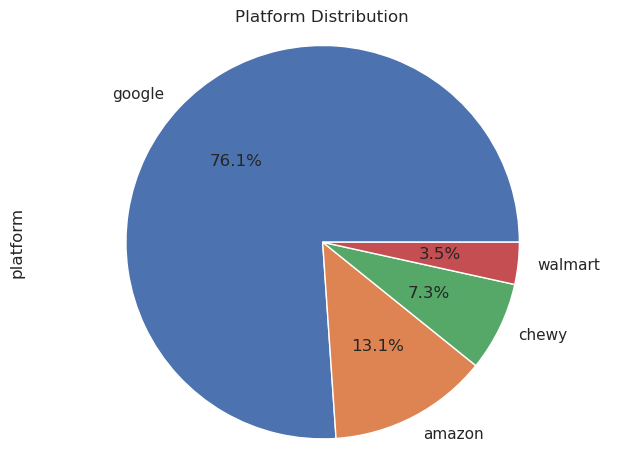

In [58]:
import matplotlib.pyplot as plt

platform_counts = google_search_data['platform'].value_counts()
platform_counts.plot.pie(autopct='%1.1f%%')
plt.axis('equal')
plt.title('Platform Distribution')
plt.show()

In [33]:
#Daily granularity
#Duplicate rows (%)	< 0.1%[drop]
#searchVolume: Kurtosis	24.002549, Skewness	3.7199833

In [49]:
google_search_data.head()

,date,platform,searchVolume,theme_id
0,2014-01-05,google,349,916
1,2014-01-06,google,349,916
2,2014-01-07,google,697,916
3,2014-01-10,google,349,916
4,2014-01-20,google,697,916


In [42]:
#drop duplicates rows
print(len(google_search_data))
google_search_data.drop_duplicates(inplace=True)
print(len(google_search_data))

181565
181525


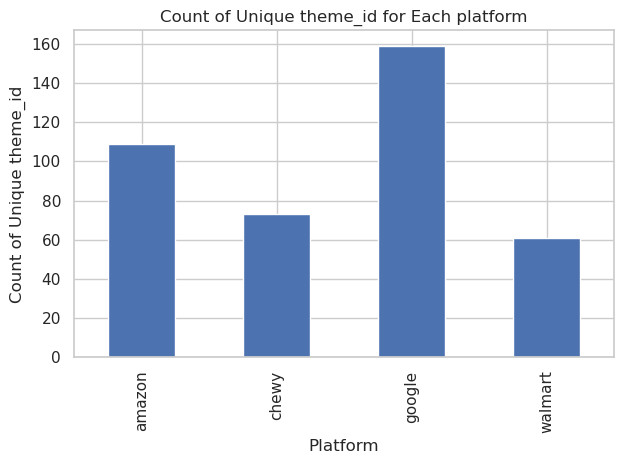

In [59]:
unique_theme_count = google_search_data.groupby('platform')['theme_id'].nunique()

# Create the bar plot
unique_theme_count.plot(kind='bar')

# Set the plot title and axis labels
plt.title('Count of Unique theme_id for Each platform')
plt.xlabel('Platform')
plt.ylabel('Count of Unique theme_id')

# Display the plot
plt.show()

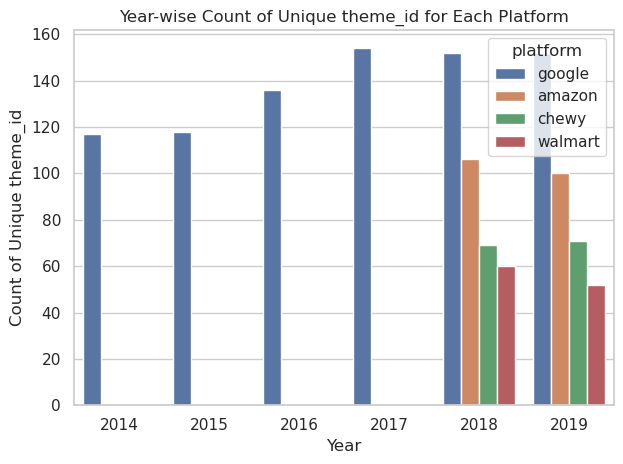

In [60]:
google_search_data['year'] = google_search_data['date'].dt.year

# Count the unique theme_id for each year and platform
unique_theme_count = google_search_data.groupby(['year', 'platform'])['theme_id'].nunique().reset_index()

# Create the bar plot using seaborn
sns.set(style="whitegrid")
sns.barplot(x='year', y='theme_id', hue='platform', data=unique_theme_count)

# Set the plot title and axis labels
plt.title('Year-wise Count of Unique theme_id for Each Platform')
plt.xlabel('Year')
plt.ylabel('Count of Unique theme_id')

# Display the plot
plt.show()

In [61]:
google_search_data.platform.unique()

array(['google', 'chewy', 'amazon', 'walmart'], dtype=object)

In [62]:
# Group by 'theme_id', 'platform', and weekly periods starting from Sunday
weekly_agg = google_search_data.groupby([pd.Grouper(key='date', freq='W-SAT'), 'theme_id', 'platform'])['searchVolume'].sum().reset_index()

# Create a new DataFrame with four different platforms
platforms = ['google', 'chewy', 'amazon', 'walmart']
new_df = weekly_agg.pivot(index=['date', 'theme_id'], columns='platform', values='searchVolume').reindex(columns=platforms)

pro_google_search_data=new_df.reset_index()

pro_google_search_data.rename(columns={'google': 'google_searchVolume', 'chewy': 'chewy_searchVolume','amazon': 'amazon_searchVolume','walmart': 'walmart_searchVolume',}, inplace=True)
pro_google_search_data=pro_google_search_data.fillna(0)
pro_google_search_data['total_searchVolume']=pro_google_search_data.google_searchVolume+ pro_google_search_data.walmart_searchVolume+pro_google_search_data.chewy_searchVolume+pro_google_search_data.amazon_searchVolume
pro_google_search_data.head()

platform,date,theme_id,google_searchVolume,chewy_searchVolume,amazon_searchVolume,walmart_searchVolume,total_searchVolume
0,2014-01-04,8,24925.0,0.0,0.0,0.0,24925.0
1,2014-01-04,39,272.0,0.0,0.0,0.0,272.0
2,2014-01-04,75,2831.0,0.0,0.0,0.0,2831.0
3,2014-01-04,81,4309.0,0.0,0.0,0.0,4309.0
4,2014-01-04,100,4613.0,0.0,0.0,0.0,4613.0


In [63]:
pro_google_search_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28600 entries, 0 to 28599
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  28600 non-null  datetime64[ns]
 1   theme_id              28600 non-null  int64         
 2   google_searchVolume   28600 non-null  float64       
 3   chewy_searchVolume    28600 non-null  float64       
 4   amazon_searchVolume   28600 non-null  float64       
 5   walmart_searchVolume  28600 non-null  float64       
 6   total_searchVolume    28600 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 1.5 MB


In [64]:
check_time_granularity(pro_google_search_data)

Weekly granularity
Mean time difference: 7 days 00:00:00
Standard deviation of time difference: 0 days 00:00:00


In [65]:
pro_google_search_data.eq(0).sum()

platform
date                        0
theme_id                    0
google_searchVolume       213
chewy_searchVolume      25098
amazon_searchVolume     23226
walmart_searchVolume    26434
total_searchVolume          0
dtype: int64

In [66]:
#pro_google_search_data.to_csv('processed_data/pro_google_search_data.csv')

save_dataset(context, pro_google_search_data, 'processed_data/google_search')

In [67]:
pro_google_search_data.theme_id.nunique()

160

### social_media_data

In [68]:
social_media_data.head(5)

,theme_id,date,total_post
0,148.0,2015-10-01,76
1,148.0,2015-10-10,31
2,148.0,2015-10-11,65
3,148.0,2015-10-12,88
4,148.0,2015-10-13,85


In [69]:
check_time_granularity(social_media_data)

Daily granularity
Mean time difference: 1 days 00:00:00
Standard deviation of time difference: 0 days 00:00:00


In [46]:
#Duplicate rows (%)	2.7%
#theme_id: Missing (%)	41.0%
#total_post: Zeros (%)	16.4%, Kurtosis	361.68507, Skewness	13.625224

In [70]:
social_media_data.head(2)

,theme_id,date,total_post
0,148.0,2015-10-01,76
1,148.0,2015-10-10,31


In [71]:
#drop the rows where missing theme_id
print(len(social_media_data))
social_media_data.dropna(inplace=True)
print(len(social_media_data))

533390
314879


In [72]:
print(len(social_media_data))
social_media_data.drop_duplicates(inplace=True)
print(len(social_media_data))

314879
314876


In [73]:
social_media_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314876 entries, 0 to 533389
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   theme_id    314876 non-null  float64       
 1   date        314876 non-null  datetime64[ns]
 2   total_post  314876 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 9.6 MB


In [74]:
social_media_data.head(2)

,theme_id,date,total_post
0,148.0,2015-10-01,76
1,148.0,2015-10-10,31


In [75]:
pro_social_media_data = social_media_data.groupby([pd.Grouper(key='date', freq='W-SAT'), 'theme_id'])['total_post'].sum().reset_index()
pro_social_media_data.head()

,date,theme_id,total_post
0,2015-05-23,8.0,307
1,2015-05-23,15.0,2
2,2015-05-23,26.0,0
3,2015-05-23,38.0,3
4,2015-05-23,39.0,4


In [76]:
check_time_granularity(pro_social_media_data)

Weekly granularity
Mean time difference: 7 days 00:00:00
Standard deviation of time difference: 0 days 00:00:00


In [77]:
#pro_social_media_data.to_csv('processed_data/pro_social_media_data.csv')

save_dataset(context, pro_social_media_data, 'processed_data/social_media')

In [78]:
pro_social_media_data.theme_id.nunique()

193

### product_manufacturer_list

In [79]:
product_manufacturer_list.head(5)

,product_id,vendor
0,1,Others
1,2,Others
2,3,Others
3,4,Others
4,5,Others


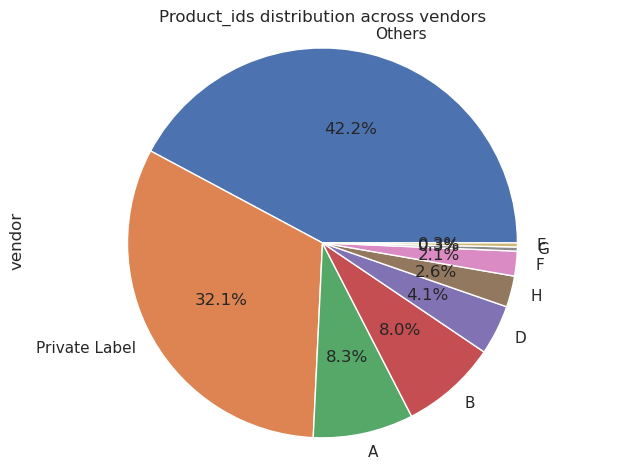

In [80]:
import matplotlib.pyplot as plt

vendor_counts = product_manufacturer_list['vendor'].value_counts()
vendor_counts.plot.pie(autopct='%1.1f%%')
plt.axis('equal')
plt.title('Product_ids distribution across vendors')
plt.show()

### Theme_product_list

In [81]:
Theme_product_list.head(5)

,product_id,theme_id
0,26,8
1,29,8
2,48,81
3,50,81
4,74,227


In [ ]:
#theme_id: Zeros (%)	31.9% -> no_claim theme
#51 distint theme_id

In [82]:
Theme_product_list.theme_id.unique()

array([  8,  81, 227, 432, 186,  58, 185, 222,  32, 220, 438, 193, 187,
       224,  40, 125, 437, 158, 430, 145, 151, 433,  65,  39,  16,  75,
       287, 228, 152,  73, 120, 385, 100,  15, 207, 163, 192, 142, 171,
       147, 148, 384, 101, 178,  59, 393,  38, 191, 157,   0, 211])

In [59]:
### Theme_list

In [83]:
Theme_list.head()

,theme_id,theme_name
0,0,No Claim
1,8,low carb
2,15,beans
3,16,cocoa
4,26,vanilla


In [84]:
gs_theme_id=pro_google_search_data.theme_id.unique()
sm_theme_id=pro_social_media_data.theme_id.unique()
product_theme_id=Theme_product_list.theme_id.unique()
all_theme_id=Theme_list.theme_id.unique()

In [ ]:
#no issue
#208 distinct theme_id and theme_name

In [85]:
product_theme_id

array([  8,  81, 227, 432, 186,  58, 185, 222,  32, 220, 438, 193, 187,
       224,  40, 125, 437, 158, 430, 145, 151, 433,  65,  39,  16,  75,
       287, 228, 152,  73, 120, 385, 100,  15, 207, 163, 192, 142, 171,
       147, 148, 384, 101, 178,  59, 393,  38, 191, 157,   0, 211])

In [86]:
p=['ethical - not specific', 'ethical', 'ethical - animal/fish & bird', 'ethical - environment', 'ethical - human', 'fish']
a=Theme_list[Theme_list.theme_name.isin(p)].theme_id
for i in a:
    if i in product_theme_id:
        print(i)
        print(Theme_list[Theme_list.theme_id==i].theme_name)

65
11    ethical - not specific
Name: theme_name, dtype: object


In [88]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import fuzz, process

themes=list(Theme_list.theme_name)
def group_themes(theme_names, threshold=60):
    grouped_themes = []

    for theme in theme_names:
        found_group = False
        for group in grouped_themes:
            if any(fuzz.ratio(theme, existing_theme) >= threshold for existing_theme in group):
                group.append(theme)
                found_group = True
                break
        if not found_group:
            grouped_themes.append([theme])

    return grouped_themes
grouped_themes = group_themes(themes)  

for group in grouped_themes:
    print(group)


['No Claim']
['low carb', 'low calorie', 'low sugar', 'carob', 'carrot', 'low fat', 'low gi', 'no added sugar']
['beans', 'bacon', 'vegan']
['cocoa', 'coconut', 'cola']
['vanilla']
['stroganoff']
['cumin', 'mint', 'pumpkin']
['high/source of protein', 'high/source of fiber']
['no additives/preservatives']
['buckwheat']
['tutti frutti']
['ethical - not specific', 'ethical - packaging', 'convenience - packaging', 'convenience - ready prepared', 'convenience - time saving', 'ethical - environment', 'ethical - human', 'functional, not specified']
['brown ale', 'bone health', 'brain health', 'eye health', 'heart health', 'heart meat', 'immune health', 'joint health', 'oral health', 'skin health', 'brownie']
['french bisque', 'french']
['pheasant', 'peanut', 'sea salt', 'meat', 'peanut butter']
['whitebait']
['gmo free', 'gluten free', 'lactose free', 'sugar free']
['peach', 'spinach']
['crab', 'cream', 'cranberry', 'rabbit', 'strawberry', 'blackberry', 'caramel']
['nuts']
['venison']
['frui

In [89]:
# product_manufacturer_list.to_csv('processed_data/pro_product_manufacturer_list.csv')
# Theme_product_list.to_csv('processed_data/pro_Theme_product_list.csv')
# Theme_list.to_csv('processed_data/pro_Theme_list.csv')


save_dataset(context, product_manufacturer_list, 'processed_data/product_manufacturer_list')
save_dataset(context, Theme_product_list, 'processed_data/Theme_product_list')
save_dataset(context, Theme_list, 'processed_data/Theme_list')

## time granularity (Daily/Weekly/Monthly/Quarterly/Yearly) for the analysis

In [98]:
# pro_sales_data=pd.read_csv('processed_data/pro_sales_data.csv', index_col=0)
# pro_google_search_data=pd.read_csv('processed_data/pro_google_search_data.csv', index_col=0)
# pro_social_media_data=pd.read_csv('processed_data/pro_social_media_data.csv', index_col=0)



pro_sales_data = load_dataset(context,'processed_data/sales')
pro_google_search_data = load_dataset(context,'processed_data/google_search')
pro_social_media_data = load_dataset(context,'processed_data/social_media')

pro_sales_data.drop("Unnamed: 0",axis = 1,inplace = True)
pro_google_search_data.drop("Unnamed: 0",axis = 1,inplace = True)
pro_social_media_data.drop("Unnamed: 0",axis = 1,inplace = True)



In [100]:
pro_social_media_data.head()

,date,theme_id,total_post
0,2015-05-23,8.0,307
1,2015-05-23,15.0,2
2,2015-05-23,26.0,0
3,2015-05-23,38.0,3
4,2015-05-23,39.0,4


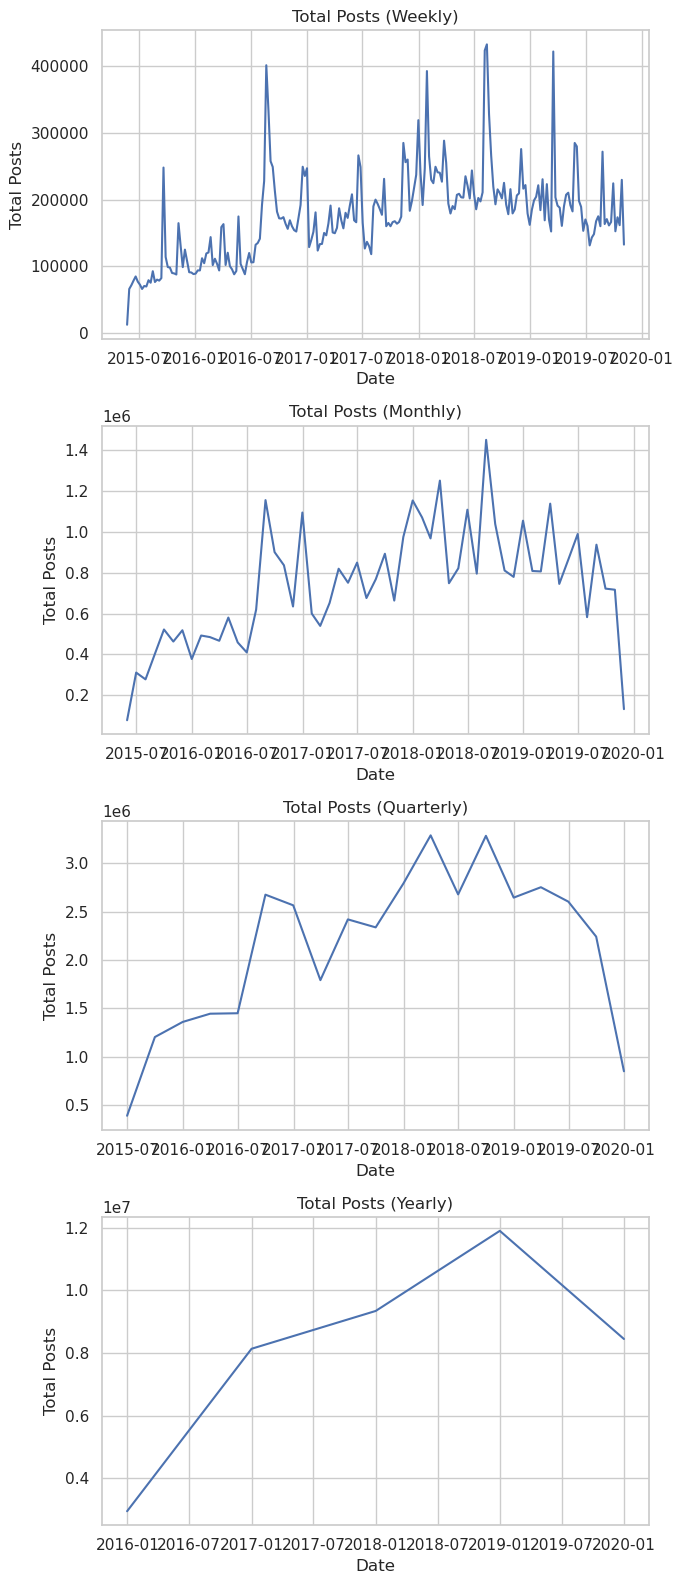

In [101]:
#pro_social_media_data=pd.read_csv('processed_data/pro_social_media_data.csv', index_col=0)
pro_social_media_data = load_dataset(context,'processed_data/social_media')
pro_social_media_data.drop("Unnamed: 0",axis = 1,inplace = True)


# Convert the 'date' column to datetime format
pro_social_media_data['date'] = pd.to_datetime(pro_social_media_data['date'])

# Set the 'date' column as the DataFrame's index
pro_social_media_data.set_index('date', inplace=True)

# Resample the DataFrame to get the desired time intervals
df_weekly = pro_social_media_data.resample('W').sum()
df_monthly = pro_social_media_data.resample('M').sum()
df_quarterly = pro_social_media_data.resample('Q').sum()
df_yearly = pro_social_media_data.resample('Y').sum()

# Plotting
fig, axes = plt.subplots(4, 1, figsize=(7, 16))

# Weekly plot
axes[0].plot(df_weekly.index, df_weekly['total_post'])
axes[0].set_title('Total Posts (Weekly)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Posts')

# Monthly plot
axes[1].plot(df_monthly.index, df_monthly['total_post'])
axes[1].set_title('Total Posts (Monthly)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Posts')

# Quarterly plot
axes[2].plot(df_quarterly.index, df_quarterly['total_post'])
axes[2].set_title('Total Posts (Quarterly)')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Total Posts')

# Yearly plot
axes[3].plot(df_yearly.index, df_yearly['total_post'])
axes[3].set_title('Total Posts (Yearly)')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Total Posts')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [102]:
#pro_google_search_data=pd.read_csv('processed_data/pro_google_search_data.csv', index_col=0)
pro_google_search_data = load_dataset(context,'processed_data/google_search')
pro_google_search_data.drop("Unnamed: 0",axis = 1,inplace = True)

pro_google_search_data.head()

,date,theme_id,google_searchVolume,chewy_searchVolume,amazon_searchVolume,walmart_searchVolume,total_searchVolume
0,2014-01-04,8,24925.0,0.0,0.0,0.0,24925.0
1,2014-01-04,39,272.0,0.0,0.0,0.0,272.0
2,2014-01-04,75,2831.0,0.0,0.0,0.0,2831.0
3,2014-01-04,81,4309.0,0.0,0.0,0.0,4309.0
4,2014-01-04,100,4613.0,0.0,0.0,0.0,4613.0


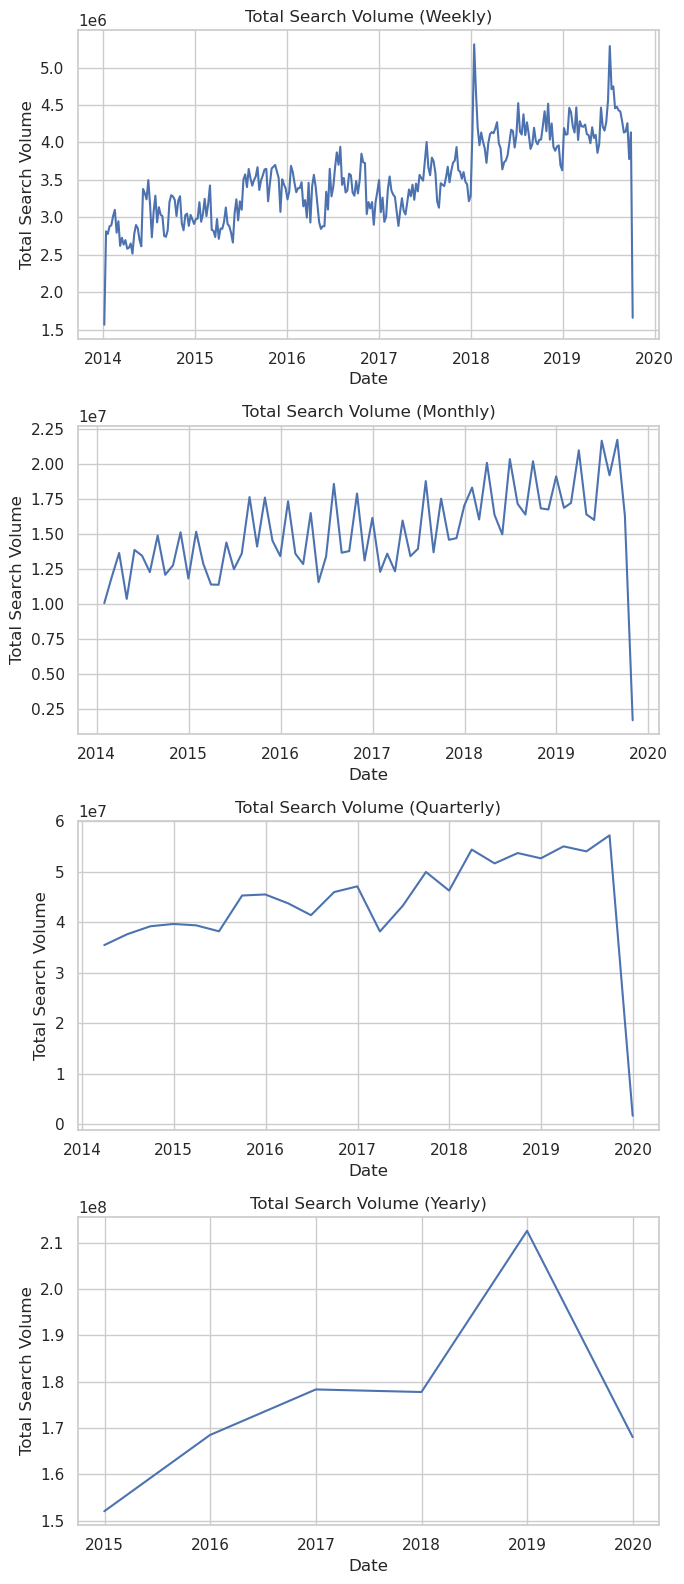

In [103]:
#pro_google_search_data=pd.read_csv('processed_data/pro_google_search_data.csv', index_col=0)
pro_google_search_data = load_dataset(context,'processed_data/google_search')
pro_google_search_data.drop("Unnamed: 0",axis = 1,inplace = True)


# Convert the 'date' column to datetime format
pro_google_search_data['date'] = pd.to_datetime(pro_google_search_data['date'])

# Set the 'date' column as the DataFrame's index
pro_google_search_data.set_index('date', inplace=True)

# Resample the DataFrame to get the desired time intervals
df_weekly = pro_google_search_data.resample('W').sum()
df_monthly = pro_google_search_data.resample('M').sum()
df_quarterly = pro_google_search_data.resample('Q').sum()
df_yearly = pro_google_search_data.resample('Y').sum()

# Plotting
fig, axes = plt.subplots(4, 1, figsize=(7, 16))

# Weekly plot
axes[0].plot(df_weekly.index, df_weekly['total_searchVolume'])
axes[0].set_title('Total Search Volume (Weekly)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Search Volume')

# Monthly plot
axes[1].plot(df_monthly.index, df_monthly['total_searchVolume'])
axes[1].set_title('Total Search Volume (Monthly)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Search Volume')

# Quarterly plot
axes[2].plot(df_quarterly.index, df_quarterly['total_searchVolume'])
axes[2].set_title('Total Search Volume (Quarterly)')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Total Search Volume')

# Yearly plot
axes[3].plot(df_yearly.index, df_yearly['total_searchVolume'])
axes[3].set_title('Total Search Volume (Yearly)')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Total Search Volume')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


In [84]:
#pro_sales_data=pd.read_csv('processed_data/pro_sales_data.csv', index_col=0)
pro_sales_data = load_dataset(context,'processed_data/sales')


pro_sales_data.head()

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value
0,2016-01-09,1,13927.0,934,18680.0
1,2016-01-09,3,10289.0,1592,28646.0
2,2016-01-09,4,357.0,22,440.0
3,2016-01-09,6,23113.0,2027,81088.0
4,2016-01-09,7,23177.0,3231,58164.0


In [104]:
df_yearly

,theme_id,google_searchVolume,chewy_searchVolume,amazon_searchVolume,walmart_searchVolume,total_searchVolume
date,,,,,,
2014-12-31,2581503,152055923.0,0.0,0.0,0.0,152055923.0
2015-12-31,2654595,168497294.0,0.0,0.0,0.0,168497294.0
2016-12-31,2836354,178340818.0,0.0,0.0,0.0,178340818.0
2017-12-31,3504989,177788861.0,0.0,0.0,0.0,177788861.0
2018-12-31,3587437,204444774.0,1584066.0,6043837.0,498344.0,212571021.0
2019-12-31,2714059,162097512.0,1492366.0,4069869.0,398627.0,168058374.0


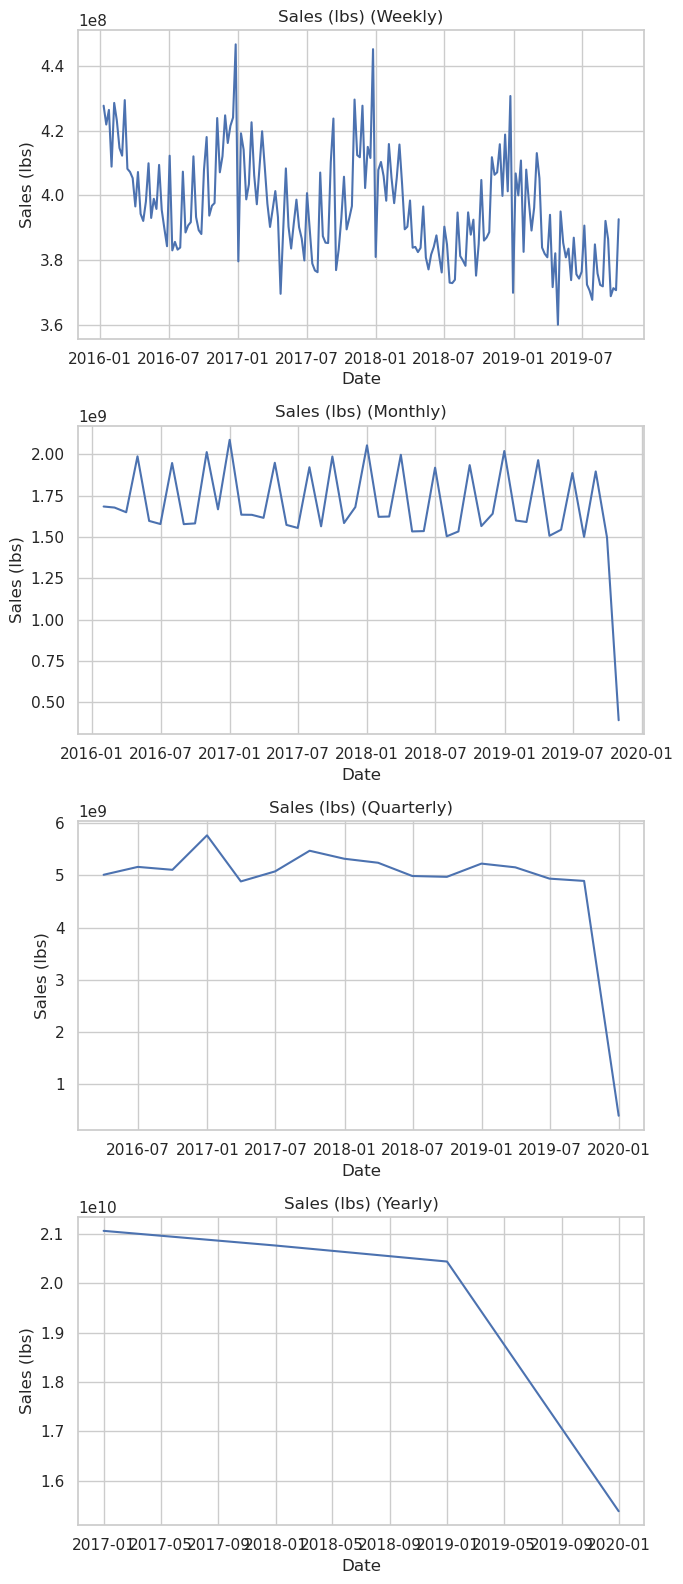

In [105]:
#pro_sales_data=pd.read_csv('processed_data/pro_sales_data.csv', index_col=0)
pro_sales_data = load_dataset(context,'processed_data/sales')
pro_sales_data.drop("Unnamed: 0",axis = 1,inplace = True)




# Convert the 'date' column to datetime format
pro_sales_data['date'] = pd.to_datetime(pro_sales_data['date'])

# Set the 'date' column as the DataFrame's index
pro_sales_data.set_index('date', inplace=True)

# Resample the DataFrame to get the desired time intervals
df_weekly = pro_sales_data.resample('W').sum()
df_monthly = pro_sales_data.resample('M').sum()
df_quarterly = pro_sales_data.resample('Q').sum()
df_yearly = pro_sales_data.resample('Y').sum()

# Plotting
fig, axes = plt.subplots(4, 1, figsize=(7, 16))

# Weekly plot
axes[0].plot(df_weekly.index, df_weekly['sales_lbs_value'])
axes[0].set_title('Sales (lbs) (Weekly)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales (lbs)')

# Monthly plot
axes[1].plot(df_monthly.index, df_monthly['sales_lbs_value'])
axes[1].set_title('Sales (lbs) (Monthly)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales (lbs)')

# Quarterly plot
axes[2].plot(df_quarterly.index, df_quarterly['sales_lbs_value'])
axes[2].set_title('Sales (lbs) (Quarterly)')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Sales (lbs)')

# Yearly plot
axes[3].plot(df_yearly.index, df_yearly['sales_lbs_value'])
axes[3].set_title('Sales (lbs) (Yearly)')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Sales (lbs)')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


## Preliminary merging

In [106]:
# pro_sales_data=pd.read_csv('processed_data/pro_sales_data.csv', index_col=0)
# pro_google_search_data=pd.read_csv('processed_data/pro_google_search_data.csv', index_col=0)
# pro_social_media_data=pd.read_csv('processed_data/pro_social_media_data.csv', index_col=0)

# pro_product_manufacturer_list = pd.read_csv('processed_data/pro_product_manufacturer_list.csv', index_col=0)
# pro_Theme_product_list = pd.read_csv('processed_data/pro_Theme_product_list.csv', index_col=0)
# pro_Theme_list = pd.read_csv('processed_data/pro_Theme_list.csv', index_col=0)


pro_sales_data = load_dataset(context,'processed_data/sales')
pro_google_search_data = load_dataset(context,'processed_data/google_search')
pro_social_media_data = load_dataset(context,'processed_data/social_media')

pro_product_manufacturer_list = load_dataset(context,'processed_data/product_manufacturer_list')
pro_Theme_product_list = load_dataset(context,'processed_data/Theme_product_list')
pro_Theme_list = load_dataset(context,'processed_data/Theme_list')


pro_sales_data.drop("Unnamed: 0",axis = 1,inplace = True)
pro_google_search_data.drop("Unnamed: 0",axis = 1,inplace = True)
pro_social_media_data.drop("Unnamed: 0",axis = 1,inplace = True)

pro_product_manufacturer_list.drop("Unnamed: 0",axis = 1,inplace = True)
pro_Theme_product_list.drop("Unnamed: 0",axis = 1,inplace = True)
pro_Theme_list.drop("Unnamed: 0",axis = 1,inplace = True)


pro_sales_data.head(5)

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value
0,2016-01-09,1,13927.0,934,18680
1,2016-01-09,3,10289.0,1592,28646
2,2016-01-09,4,357.0,22,440
3,2016-01-09,6,23113.0,2027,81088
4,2016-01-09,7,23177.0,3231,58164


### sales_data

In [107]:
# Merge sales_data with product_manufacturer_list
merge1 = pd.merge(pro_sales_data, pro_product_manufacturer_list, how='inner', on='product_id')

# Merge the result with Theme_product_list
merge_sales_data = pd.merge(merge1, pro_Theme_product_list, how='inner', on='product_id')
merge_sales_data = pd.merge(merge_sales_data, pro_Theme_list, how='inner', on='theme_id')

merge_sales_data.head()

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,vendor,theme_id,theme_name
0,2016-01-09,1,13927.0,934,18680,Others,0,No Claim
1,2016-01-23,1,12628.0,878,17564,Others,0,No Claim
2,2016-02-06,1,11379.0,810,16200,Others,0,No Claim
3,2016-01-30,1,11568.0,821,16424,Others,0,No Claim
4,2016-02-13,1,10959.0,784,15682,Others,0,No Claim


In [108]:
merge_sales_data.theme_id.nunique()

49

In [109]:
unique_theme_count

,year,platform,theme_id
0,2014,google,117
1,2015,google,118
2,2016,google,136
3,2017,google,154
4,2018,amazon,106
5,2018,chewy,69
6,2018,google,152
7,2018,walmart,60
8,2019,amazon,100
9,2019,chewy,71


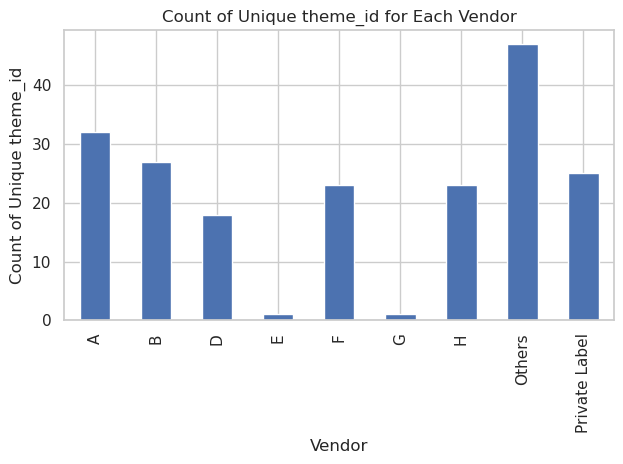

In [110]:
unique_theme_count = merge_sales_data.groupby('vendor')['theme_id'].nunique()

# Create the bar plot
unique_theme_count.plot(kind='bar')

# Set the plot title and axis labels
plt.title('Count of Unique theme_id for Each Vendor')
plt.xlabel('Vendor')
plt.ylabel('Count of Unique theme_id')

# Display the plot
plt.show()

In [111]:
len(merge_sales_data)

7699708

In [112]:
len(pro_sales_data)

4471821

In [117]:
# merge_sales_data.to_csv('processed_data/merge_sales_data.csv')
save_dataset(context, merge_sales_data, 'merged_data/sales')


## google_search_data

In [118]:
# For google_search_data, merge with Theme_list
merge_google_search_data = pd.merge(pro_google_search_data, pro_Theme_list, how='inner', on='theme_id')
merge_google_search_data.head(5)

,date,theme_id,google_searchVolume,chewy_searchVolume,amazon_searchVolume,walmart_searchVolume,total_searchVolume,theme_name
0,2014-01-04,8,24925.0,0.0,0.0,0.0,24925.0,low carb
1,2014-01-11,8,39804.0,0.0,0.0,0.0,39804.0,low carb
2,2014-01-18,8,55316.0,0.0,0.0,0.0,55316.0,low carb
3,2014-01-25,8,40947.0,0.0,0.0,0.0,40947.0,low carb
4,2014-02-01,8,44253.0,0.0,0.0,0.0,44253.0,low carb


In [119]:
#merge_google_search_data.to_csv('processed_data/merge_google_search_data.csv')


save_dataset(context, merge_google_search_data, 'merged_data/google_search')


## social_media_data

In [120]:
# For social_media_data, merge with Theme_list
merge_social_media_data = pd.merge(pro_social_media_data, pro_Theme_list, how='inner', on='theme_id')
merge_social_media_data.head(5)

,date,theme_id,total_post,theme_name
0,2015-05-23,8.0,307,low carb
1,2015-05-30,8.0,923,low carb
2,2015-06-06,8.0,1705,low carb
3,2015-06-13,8.0,1089,low carb
4,2015-06-20,8.0,913,low carb


In [122]:
#merge_social_media_data.to_csv('processed_data/merge_social_media_data.csv')


save_dataset(context, merge_social_media_data, 'merged_data/social_media')


# Understands consumer preference(themes) available in each data source

In [124]:
# merge_sales_data=pd.read_csv('processed_data/merge_sales_data.csv', index_col=0)
# merge_google_search_data=pd.read_csv('processed_data/merge_google_search_data.csv', index_col=0)
# merge_social_media_data=pd.read_csv('processed_data/merge_social_media_data.csv', index_col=0)


merge_sales_data = load_dataset(context,'merged_data/sales')
merge_google_search_data = load_dataset(context,'merged_data/google_search')
merge_social_media_data = load_dataset(context,'merged_data/social_media')


merge_sales_data.drop("Unnamed: 0",axis = 1,inplace = True)
merge_google_search_data.drop("Unnamed: 0",axis = 1,inplace = True)
merge_social_media_data.drop("Unnamed: 0",axis = 1,inplace = True)

merge_sales_data['date'] = pd.to_datetime(merge_sales_data['date'])
merge_google_search_data['date'] = pd.to_datetime(merge_google_search_data['date'])
merge_social_media_data['date'] = pd.to_datetime(merge_social_media_data['date'])

In [125]:
common_theme_name=list(set(merge_sales_data.theme_name) & set(merge_google_search_data.theme_name) & set(merge_social_media_data.theme_name))
len(common_theme_name)

30

In [126]:
merge_sales_data=merge_sales_data[merge_sales_data.theme_name.isin(common_theme_name)]
merge_google_search_data=merge_google_search_data[merge_google_search_data.theme_name.isin(common_theme_name)]
merge_social_media_data=merge_social_media_data[merge_social_media_data.theme_name.isin(common_theme_name)]

#### merge_sales_data

In [127]:
merge_sales_data.head(5)

,date,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,vendor,theme_id,theme_name
2012974,2016-01-09,37,1101.0,159,105,Others,158,chicken
2012975,2016-01-23,37,1101.0,159,105,Others,158,chicken
2012976,2016-02-06,37,1101.0,159,105,Others,158,chicken
2012977,2016-01-30,37,1001.0,145,95,Others,158,chicken
2012978,2016-02-13,37,886.0,127,83,Others,158,chicken


In [128]:
merge_sales_data.groupby('theme_name')['sales_lbs_value'].sum().sort_values(ascending=False)

theme_name
low carb                         6498688986
no additives/preservatives       5611153391
salmon                           1984007727
soy foods                        1597301799
gmo free                         1492290161
blueberry                        1449127346
ethnic & exotic                  1400716455
low sodium                        306163353
low calorie                       200970349
crab                              197525697
high/source of protein            106413307
ethical - packaging                91587845
chicken                            86933963
french bisque                      66881849
gingerbread                        56007241
vegetarian                         53838019
poultry                            34656041
low sugar                           9356675
nuts                                8528550
convenience - easy-to-prepare       2991362
prebiotic                           1985817
peach                               1816945
energy/alertness     

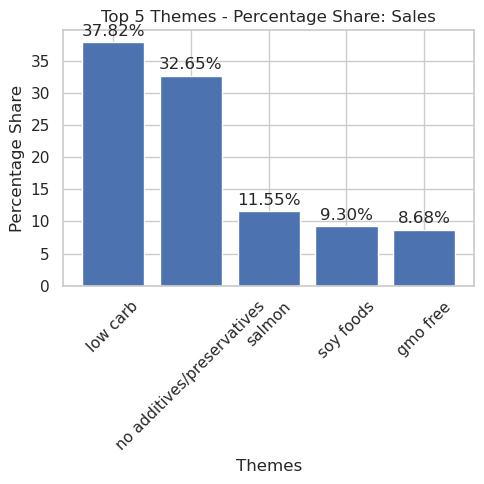

In [130]:
# Calculate the sales sum for each theme and sort in descending order
theme_sales = merge_sales_data.groupby('theme_name')['sales_lbs_value'].sum().sort_values(ascending=False)

# Select the top 5 themes
top_themes = theme_sales.head(5)

# Calculate the percentage share for each theme
percentage_share = (top_themes / top_themes.sum()) * 100

# Plotting the histogram
plt.figure(figsize=(5, 5))
plt.bar(percentage_share.index, percentage_share.values)
plt.xlabel('Themes')
plt.ylabel('Percentage Share')
plt.title('Top 5 Themes - Percentage Share: Sales')

# Add percentage values above each bar
for i, v in enumerate(percentage_share.values):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center')

plt.xticks(rotation=45)
plt.show()

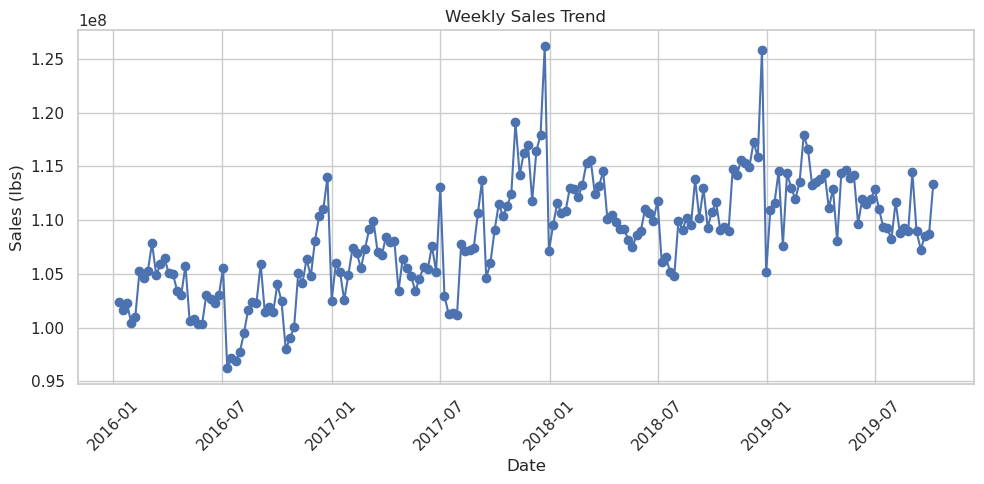

In [132]:
# Resample the data at a different frequency, e.g., weekly
weekly_sales = merge_sales_data.set_index('date')['sales_lbs_value'].resample('W').sum()

# Plotting the trend
plt.figure(figsize=(10, 5))
plt.plot(weekly_sales.index, weekly_sales.values, marker='o')
plt.xlabel('Date')
plt.ylabel('Sales (lbs)')
plt.title('Weekly Sales Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### merge_google_search_data

In [133]:
merge_google_search_data.head()

,date,theme_id,google_searchVolume,chewy_searchVolume,amazon_searchVolume,walmart_searchVolume,total_searchVolume,theme_name
0,2014-01-04,8,24925.0,0.0,0.0,0.0,24925.0,low carb
1,2014-01-11,8,39804.0,0.0,0.0,0.0,39804.0,low carb
2,2014-01-18,8,55316.0,0.0,0.0,0.0,55316.0,low carb
3,2014-01-25,8,40947.0,0.0,0.0,0.0,40947.0,low carb
4,2014-02-01,8,44253.0,0.0,0.0,0.0,44253.0,low carb


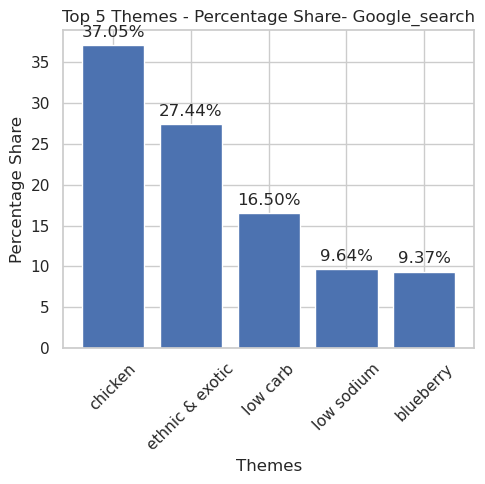

In [134]:
# Calculate the sales sum for each theme and sort in descending order
theme_sales = merge_google_search_data.groupby('theme_name')['total_searchVolume'].sum().sort_values(ascending=False)

# Select the top 5 themes
top_themes = theme_sales.head(5)

# Calculate the percentage share for each theme
percentage_share = (top_themes / top_themes.sum()) * 100

# Plotting the histogram
plt.figure(figsize=(5, 5))
plt.bar(percentage_share.index, percentage_share.values)
plt.xlabel('Themes')
plt.ylabel('Percentage Share')
plt.title('Top 5 Themes - Percentage Share- Google_search')

# Add percentage values above each bar
for i, v in enumerate(percentage_share.values):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center')

plt.xticks(rotation=45)
plt.show()

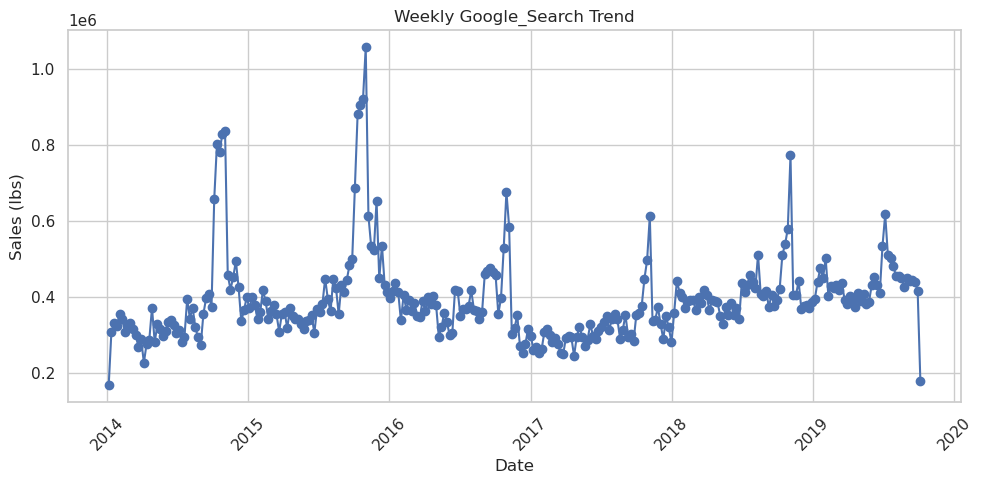

In [135]:
# Resample the data at a different frequency, e.g., weekly
weekly_sales = merge_google_search_data.set_index('date')['total_searchVolume'].resample('W').sum()

# Plotting the trend
plt.figure(figsize=(10, 5))
plt.plot(weekly_sales.index, weekly_sales.values, marker='o')
plt.xlabel('Date')
plt.ylabel('Sales (lbs)')
plt.title('Weekly Google_Search Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### merge_social_media_data

In [136]:
merge_social_media_data.head()

,date,theme_id,total_post,theme_name
0,2015-05-23,8.0,307,low carb
1,2015-05-30,8.0,923,low carb
2,2015-06-06,8.0,1705,low carb
3,2015-06-13,8.0,1089,low carb
4,2015-06-20,8.0,913,low carb


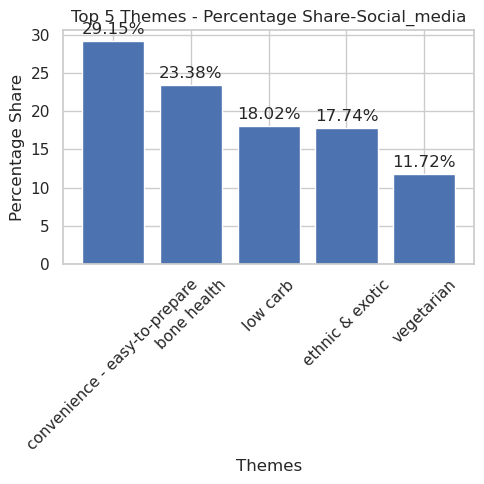

In [137]:
# Calculate the sales sum for each theme and sort in descending order
theme_sales = merge_social_media_data.groupby('theme_name')['total_post'].sum().sort_values(ascending=False)

# Select the top 5 themes
top_themes = theme_sales.head(5)

# Calculate the percentage share for each theme
percentage_share = (top_themes / top_themes.sum()) * 100

# Plotting the histogram
plt.figure(figsize=(5, 5))
plt.bar(percentage_share.index, percentage_share.values)
plt.xlabel('Themes')
plt.ylabel('Percentage Share')
plt.title('Top 5 Themes - Percentage Share-Social_media')

# Add percentage values above each bar
for i, v in enumerate(percentage_share.values):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center')

plt.xticks(rotation=45)
plt.show()

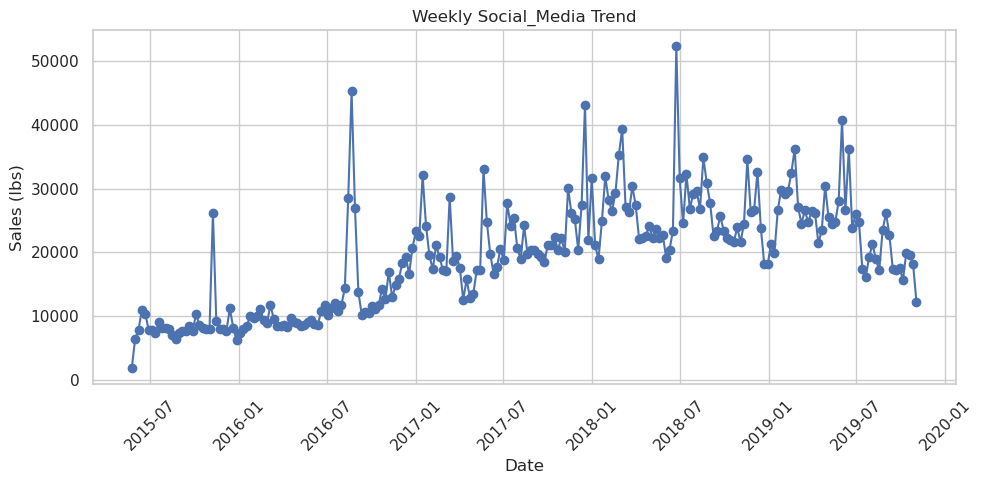

In [138]:
# Resample the data at a different frequency, e.g., weekly
weekly_sales = merge_social_media_data.set_index('date')['total_post'].resample('W').sum()

# Plotting the trend
plt.figure(figsize=(10, 5))
plt.plot(weekly_sales.index, weekly_sales.values, marker='o')
plt.xlabel('Date')
plt.ylabel('Sales (lbs)')
plt.title('Weekly Social_Media Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()